# Combining Process and Auths 

In [1]:
from pyCP_APR import CP_APR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os
import os.path
import gzip
import shutil
import datetime
import networkx as nx
import pickle
from scipy import stats
from scipy import sparse
import bz2
import random
import regex as re
from tqdm.notebook import tqdm
import scipy

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score

from IPython.display import clear_output

import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tqdm.keras import TqdmCallback

In [2]:
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [3]:
try:
    print('Attempting to read entire data set.')
    authentication_data = pd.read_csv('../../../Data/Authentication data.gz', compression='gzip', index_col = 0)
    process_data = pd.read_csv('../../../Data/Process data.gz', compression='gzip', index_col = 0)
except:
    clear_output()
    print('Unable to read entire data set, reading from original files.')
    rootdir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls'
    unzippeddir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls/Unzipped'
    frames = []

    count = 0
    
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file[-3:] == '.gz':
                filedir = rootdir + '/' + file
                with gzip.open(filedir) as f:
                    df = pd.read_csv(filedir, header=None)
                    frames.append(df)
                if 'authentications' in str(file):
                    count = count + len(df)
    
    df = pd.concat(frames)

    authentication_data = df[:count]
    authentication_data.columns = ['UserName', 'SrcDevice','DstDevice', 'Authent Type', 'Failure', 'DailyCount']

    process_data = df[count:]
    process_data = process_data[[0,1,2,3,4]]
    process_data.columns = ['UserName', 'Device', 'ProcessName', 'ParentProcessName', 'DailyCount']

    authentication_data.to_csv('../Data/Authentication data.gz', header=True, compression='gzip')
    process_data.to_csv('../Data/Process data.gz', header=True, compression='gzip')

Attempting to read entire data set.


C:\Users\corri\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
rt_usernames = list(pd.read_csv('../../../Data/AuthUserNames.txt', header=None)[0])
non_rt_users = [un for un in authentication_data['UserName'].unique() if un not in rt_usernames]
non_rt_sample = pickle.load (open('../Final Anomaly Detection/Random Sample of Non Red Team Usernames.p','rb'))

In [5]:
a_t = list(authentication_data['Authent Type'].unique())
AT_dict = { i : a_t[i] for i in range(0, len(a_t) ) }

In [6]:
auth_index_list = authentication_data.index.tolist()
auth_start_days = [i for i, e in enumerate(auth_index_list) if e == 0]
auth_start_days.append(len(authentication_data))
proc_index_list = process_data.index.tolist()
proc_start_days = [i for i, e in enumerate(proc_index_list) if e == 0]
proc_start_days.append(len(process_data))

In [7]:
def split_dataframe(df,n):
    chunks = list()
    chunk_size = int(np.round(df.shape[0]/n))
    num_chunks = n
    for i in range(num_chunks):
        if i != num_chunks-1:
            chunks.append(df[i*chunk_size:(i+1)*chunk_size])
        else:
            chunks.append(df[i*chunk_size:])
    return chunks

In [8]:
def feature_generation(user,n):
    
    n = n
    feat_dict_auth = {}
    feat_dict_proc = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                uniquepairs = len(data[data['UserName'] == user].groupby(['SrcDevice','DstDevice']).size())
                feat_dict_auth[i*n + j] = [day,srcunique,dstunique,uniquepairs,authents,failures]
    
    df1 = pd.DataFrame(data=feat_dict_auth,index =  ['Day','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df1 = df1.transpose()
    df1 = df1.fillna(0)
    
    for i in range(len(proc_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(process_data[proc_start_days[i]:proc_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                processes = len(data[data['UserName'] == user])
                devices = len(data[data['UserName'] == user]['Device'].unique())
                uniquepairs = len(data[data['UserName'] == user].groupby(['ProcessName','ParentProcessName']).size())
                uniqueproc = len(data[data['UserName'] == user]['ProcessName'].unique())
                feat_dict_proc[i*n + j] = [processes,devices,uniquepairs,uniqueproc]
    
    df2 = pd.DataFrame(data=feat_dict_proc,index =  ['Processes','Devices','UniquePairs','UniqueProc'])
    df2 = df2.transpose()
    df2 = df2.fillna(0)
    
    df = pd.concat([df1, df2], axis=1)
    
    return df

In [9]:
def ae_orig_finder(user,n,idx):
    
    j_idx = idx % n
    i_idx = int(idx/n)

    chunks = split_dataframe(authentication_data[auth_start_days[i_idx]:auth_start_days[i_idx+1]],n)
    chunks_proc = split_dataframe(process_data[proc_start_days[i_idx]:proc_start_days[i_idx+1]],n)
    data = chunks[j_idx][chunks[j_idx]['UserName'] == user]
    data_proc = chunks_proc[j_idx][chunks_proc[j_idx]['UserName'] == user]
    data['Hour'] = [j_idx]*len(data)
    data['Day'] = [i_idx+1]*len(data)
    
    
    return data, data_proc

In [10]:
def ae_anomaly_finder(user,n,BATCH_SIZE=64, EPOCHS=1000):
    
    clear_output()
    
    # get the data frame of features
    df = feature_generation(user,n)
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    
    frame = []
    frame_proc = []
    for i in range(len(anomaly_idx)):
        anomaly,anomaly_proc = ae_orig_finder(user,n,57*n+anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) > 0:
            frame.append(anomaly)
        
        if len(anomaly_proc) > 0:
            frame_proc.append(anomaly_proc)
        
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        anomaly_proc_df = pd.concat(frame)
        return anomaly_df,anomaly_proc_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return [],[],0,history.history["val_loss"]

In [11]:
def simple_ae_eval(anomaly_bools,anomalies,val_losses,usernames,type_un,typedata):
    if typedata == 'auth':
        print('Authentication Anoms')
        print('--------------')
        non_anom = []
        for i in range(len(anomaly_bools)):
            if anomaly_bools[i][0] == 0:    
                non_anom.append(anomaly_bools[i][1])

        anom = []
        for i in range(len(anomaly_bools)):
            if anomaly_bools[i][0] != 0:    
                anom.append(anomaly_bools[i][1])

        print('{} of the {} usernames were identified to have anomalies out of {} {} usernames. The folloiwng usernames were found to have no anomalies'.
              format(len(np.where(np.array([i[0] for i in anomaly_bools]) > 0)[0]),type_un,len(anomaly_bools),type_un))
        print('--------------------------------------------------------------------------------------------')        
        print(', '.join(map(str,non_anom)))

        perc = 100*len(anomalies)/len(authentication_data[authentication_data['UserName'].isin(usernames)])
        print('{:.2f}% of the {} data was identified as anomalous.'.format(perc,type_un))

        final_losses = []
        for i in range(len(val_losses)):
            final_losses.append(val_losses[i][0][len(val_losses[i][0])-1]) 

        plt.figure()
        sns.boxplot(data = final_losses)
        plt.show()

        anomalies.head()
    else:
        print('Process Anoms')
        print('--------------')
        non_anom = []
        for i in range(len(anomaly_bools)):
            if anomaly_bools[i][0] == 0:    
                non_anom.append(anomaly_bools[i][1])

        anom = []
        for i in range(len(anomaly_bools)):
            if anomaly_bools[i][0] != 0:    
                anom.append(anomaly_bools[i][1])

        print('{} of the {} usernames were identified to have anomalies out of {} {} usernames. The folloiwng usernames were found to have no anomalies'.
              format(len(np.where(np.array([i[0] for i in anomaly_bools]) > 0)[0]),type_un,len(anomaly_bools),type_un))
        print('--------------------------------------------------------------------------------------------')        
        print(', '.join(map(str,non_anom)))

        perc = 100*len(anomalies)/len(process_data[process_data['UserName'].isin(usernames)])
        print('{:.2f}% of the {} data was identified as anomalous.'.format(perc,type_un))

        final_losses = []
        for i in range(len(val_losses)):
            final_losses.append(val_losses[i][0][len(val_losses[i][0])-1]) 

        plt.figure()
        sns.boxplot(data = final_losses)
        plt.show()

        anomalies.head()
    return

In [12]:
frames_5 = []
frames_5_proc = []
anomaly_bool_5 = []
val_loss_5 = []

s_time = datetime.datetime.now()

for i,un in enumerate(set(rt_usernames)):
    clear_output(wait=True)
    print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
    f,f_p,b,val = ae_anomaly_finder(un,24)
    if b == 1:
        if len(f) > 0:
            frames_5.append(f)
        if len(f_p) > 0:
            frames_5_proc.append(f)
        anomaly_bool_5.append((len(f),un))
        val_loss_5.append((val,un))
    else:
        anomaly_bool_5.append((0,un))
        val_loss_5.append((val,un))
        pass
anomalies_ae_5 = pd.concat(frames_5)
anomalies_ae_5_proc = pd.concat(frames_5_proc)
e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:53:16.578823


Authentication Anoms
--------------
94 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
30.19% of the red team data was identified as anomalous.


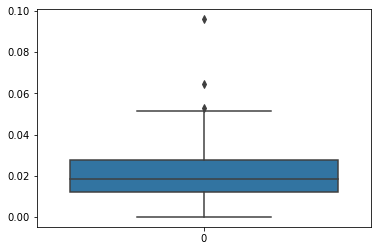

Process Anoms
--------------
94 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
23.70% of the red team data was identified as anomalous.


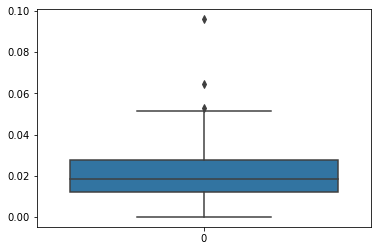

In [13]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,set(rt_usernames),'red team','auth')
simple_ae_eval(anomaly_bool_5,anomalies_ae_5_proc,val_loss_5,set(rt_usernames),'red team','process')

In [15]:
frames_n_5 = []
frames_n_5_process = []
anomaly_bool_N_5 = []
val_loss_n_5 = []
bound = 400

s_time = datetime.datetime.now()

for i,un in enumerate(non_rt_sample):
    f,f_p,b,val = ae_anomaly_finder(un,24)
    if b == 1:
        if len(f) > 0:
            frames_n_5.append(f)
        if len(f_p) > 0:
            frames_n_5_process.append(f_p)
        anomaly_bool_N_5.append((len(f),un))
        val_loss_n_5.append((val,un))
    else:
        anomaly_bool_N_5.append((0,un))
        val_loss_n_5.append((val,un))
        pass
anomalies_ae_n_5 = pd.concat(frames_n_5)
anomalies_ae_n_5_proc = pd.concat(frames_n_5_process)
e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


1:42:43.786422


Authentication Anoms
--------------
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
29.17% of the normal data was identified as anomalous.


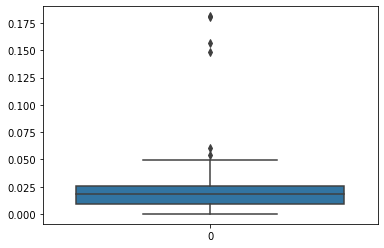

Process Anoms
--------------
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
6.96% of the normal data was identified as anomalous.


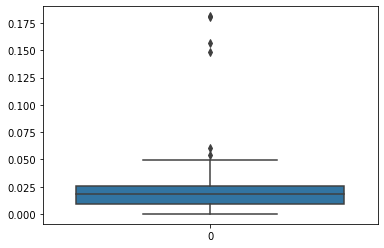

In [16]:
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,non_rt_sample,'normal','auth')
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5_proc,val_loss_n_5,non_rt_sample,'normal','proc')